*This exercise was part of the "Applied Plotting and Data Representation" course from University of Michigan. As the capstone project, the goal was to state a question about "economic activity" in Ann Arbor, MI. Then, we had to combine two datasets and create a figure that answered that question.*

### Introduction
**Are home prices in wealthier areas more susceptible to economic variability?** For example -- when there is a recession, there's a strong possibility that it will be the largest houses that people stop paying for, rather than the smaller ones. 

The housing data was pulled from Zillow, a real estate tracking website. This data covers the period 1997-2016, and is broken out by the house size (number of beds) and zip code. The data api can be seen here (https://www.zillow.com/mi/home-values/) and the actual datasets are available on Github ([1_bedroom]({{ site.baseurl ....}}), 2_bedroom, etc.) This data includes a "Metro" field, which associates all zip codes near Ann Arbor with the city, and this is what I used to filter on. 

The second dataset was pulled from the IRS website and contains aggregated tax return data by zip code. This was filtered by the Ann Arbor zip codes found in the housing data. To find out the "high wealth" zip codes, I took the number of returns filed with adjusted gross incomes greater than $200,000, and I divided it by the total number of returns. This is a rough approximation for the distribution of wealth in a given zip code, but it is rough. The link to the IRS data is https://www.irs.gov/uac/soi-tax-stats-historic-table-2. The link to the excel data is available on Github: https://raw.githubusercontent.com/stkbailey/Coursera_Plotting/master/AGI2014_Michigan.csv. 

### Build the Income Distributions

The field `agi_stub` shows the size of Adjusted Gross Income for tax returns filed in this area.

    # agi_stub = {1: '<25k', 2: '25k-50k', 3: '50k-75k',4: '75k-100k', 5: '100k-200k', 6: '>200k'}


In [1]:
import pandas as pd 
import numpy as np

# Download the data from Github
raw = pd.read_csv('http://stkbailey.github.io/assets/matplotlib_michigan/AGI2014_Michigan.csv')

# Selecta few important columns and rename them 
col_rename = {'zipcode': 'RegionName', 'N1': 'num_returns', 'agi_stub': 'agi_group'}
tdf = raw[list(col_rename.keys())].rename(columns=col_rename)

# Summarize within income bin
income = tdf.pivot(index='RegionName', columns='agi_group', values='num_returns')

income.columns = ['agi_{}'.format(c) for c in income.columns]
income['num_total'] = income.sum(axis=1)
income.head(5)

,agi_1,agi_2,agi_3,agi_4,agi_5,agi_6,num_total
RegionName,,,,,,,
0,1906120,1024390,618690,408200,522800,141160,4621360
48001,2370,1290,900,570,650,110,5890
48002,560,320,220,190,260,0,1550
48003,1070,600,440,360,500,50,3020
48005,860,520,420,300,480,50,2630


### Build Zillow Dataframe for Ann Arbor
The Zillow data is held separately for each bedroom class, so we need to build each dataframe then merge them together.

In [3]:
import datetime as dt

# Initialize an empty dataframe to append to
zdf = pd.DataFrame()

for numbeds in np.arange(1,6):
    # Read in data to a temporary dataframe and assign bed number
    zillow_path = 'http://stkbailey.github.io/assets/matplotlib_michigan/Zillow_{}b.csv'.format(numbeds)
    tdf = pd.read_csv(zillow_path)
    tdf['beds'] = numbeds

    # Convert Date Strings to DateTime
    ocols = [c for c in tdf.columns if '-' in c]
    tcols = [dt.datetime(int(c.split('-')[0]), int(c.split('-')[1]), 1) for c in ocols]

    # Apply Filtering operations and rename index
    tdf = (tdf.loc[tdf.Metro == 'Ann Arbor']
               .rename(columns=dict(zip(ocols, tcols))) 
               .drop(tdf.loc[tdf.RegionName==48191].index))
    tdf.index = ['{}_{}'.format(x,y) for x,y in zip(tdf.RegionName, tdf.beds)]

    # Append to zdf
    zdf = zdf.append(tdf)
    del tdf

In [4]:
zdf.iloc[0][0:15]

RegionID                   79054
RegionName                 48197
City                   Ypsilanti
State                         MI
Metro                  Ann Arbor
CountyName             Washtenaw
SizeRank                      69
1996-04-01 00:00:00       116000
1996-05-01 00:00:00       118800
1996-06-01 00:00:00       120700
1996-07-01 00:00:00       122700
1996-08-01 00:00:00       124400
1996-09-01 00:00:00       125100
1996-10-01 00:00:00       125800
1996-11-01 00:00:00       126700
Name: 48197_1, dtype: object

In [5]:
### Combine the data

# Merge the two datasets on the zip code
df = zdf.join(income, on='RegionName', how='inner')

# Bin the zipcodes by their percentage of high earners 
df['pct_high'] = df.apply(lambda s: s.agi_6/s.num_total, axis=1)
gdf = df.groupby('RegionName').agg({'pct_high': np.mean}).sort_values(by='pct_high')
lowZips = gdf.iloc[0:4].index
midZips = gdf.iloc[4:8].index
highZips = gdf.iloc[8:12].index

# Pull a list of cols to use for timeseries plots
datecols = [c for c in df.columns if type(c) == dt.datetime]


In [6]:
# Define plotting functions
import matplotlib.pyplot as plt
import seaborn as sns
    
def drawTimeseries(nbeds, win=12):
    ax1 = plt.subplot(gspec[1:4,0], frameon=False)
    ax1.cla()

    # Establish Data
    lowprice = (df.loc[df.RegionName.isin(lowZips) & (df.beds==nbeds), datecols].T
                    .rolling(window=win).mean() ) / 1000
    highprice = (df.loc[df.RegionName.isin(highZips) & (df.beds==nbeds), datecols].T
                     .rolling(window=win).mean() ) / 1000
    midprice = (df.loc[df.RegionName.isin(midZips) & (df.beds==nbeds), datecols].T
                    .rolling(window=win).mean() ) / 1000

    # Plot Timseries Data
    lowprice.plot(linestyle=':', ax=ax1, alpha=0.2, color='blue')
    highprice.plot(linestyle=':', ax=ax1, alpha=0.2, color='green')
    lowprice.mean(axis=1).plot(ax=ax1, alpha=1.0, linewidth=3, color='blue')
    highprice.mean(axis=1).plot(ax=ax1, alpha=1.0, linewidth=3, color='green')

    # Ax1 Style
    ax1.set_title('Mean Home Price for {} Bedroom Houses'.format(nbeds), weight='bold', y=0.95)
    ax1.legend_.remove()
    ax1.set_ylim([0,500])
    ax1.set_yticks([150, 250, 350, 450])
    ax1.set_yticklabels(['$150k', '$250k', '$350k', '$450k'])
    ax1.grid(b=True, which='major', axis='y', color='lightgrey')
    ax1.tick_params(left=True, labelleft=True, bottom=False, labelbottom=False)

    return ax1


def drawDiffseries(nbeds, win=12):
    ax2 = plt.subplot(gspec[4:7,0], frameon=False)
    ax2.cla()

    # Set Data
    lowdiff = (df.loc[df.RegionName.isin(lowZips) & (df.beds==nbeds), datecols].mean().T.diff()
                    .rolling(window=win).mean().apply(np.abs) ) / 1000
    highdiff = (df.loc[df.RegionName.isin(highZips) & (df.beds==nbeds), datecols].mean().T.diff()
                    .rolling(window=win).mean().apply(np.abs) ) / 1000

    # Plot Differential Timeseries Data
    lowdiff.plot(ax=ax2, color='blue')
    highdiff.plot(ax=ax2, color='green')
    plt.fill_between(lowdiff.index, highdiff, lowdiff, where=(highdiff>lowdiff), color='green', alpha=0.1)
    plt.fill_between(lowdiff.index, highdiff, lowdiff, where=(highdiff<lowdiff), color='blue', alpha=0.1)

    # Set Ax2 Style
    ax2.set_title('Price Change by Month (Abs. Value)', weight='bold', y=0.95)
    ax2.set_xlabel('Year')
    ax2.set_ylim([0,3])
    ax2.set_yticks([0.5, 1.5, 2.5])
    ax2.set_yticklabels(['$500', '$1500', '$2500'])
    ax2.tick_params(left=True, labelleft=True, bottom=True, labelbottom=True, color='lightgrey')
    ax2.grid(b=True, which='major', axis='y', color='lightgrey')
    
    return ax2


def drawZipCodes():
    pcts = df.groupby('RegionName').agg({'pct_high':np.mean}).sort_values(by='pct_high')
    pcts['pct_rest'] = 1 - pcts['pct_high']
    ind=0
    for row in np.arange(1,7):
        for col in [1,2]:
            ax = plt.subplot(gspec[row,col], frameon=False)
            ax.pie(pcts.iloc[ind], colors=['r', 'w'], shadow=True)
            zipcode = pcts.index[ind]
            if zipcode in lowZips:
                color = 'blue'
            elif zipcode in midZips:
                color = 'black'
            elif zipcode in highZips:
                color = 'green'
            ax.set_title(pcts.index[ind], y=0.75, color=color)
            ind+=1

Now we have a nice dataset that is organized by ZIPCODE_BEDROOMS, and which has timeseries data related to housing price. We also know which zip codes have a higher percentage of "high earners" -- those with an AGI greater than $250k per year. 

We're going to make a couple of plots:
- Mean housing price over time (with min/max lines)
- Monthly change in mean price 
- Percent of high earners in each zip code

I also made this plot **interactive** -- at the push of a button, you can select which number of bedrooms you want to use. Unfortunately, this feature isn't available in Jekyll, so you'll have to take my word for it. 

For the sake of brevity, I'm only going to show you the code for the overall plot and button functionality. But let's show you the final product first!

#### Create the figure
GridSpec is a nifty tool to give you tighter control over figures with multiple subplots. It creates a grid over your figure and gives you the ability to specify which portions should be covered by new figures.

To create the buttons, we have three steps:
- Create the rectangular button objects
- Create an Index object with "redraw" functions for redrawing the plots on press
- Tie the shapes to the functions

<IPython.core.display.Javascript object>


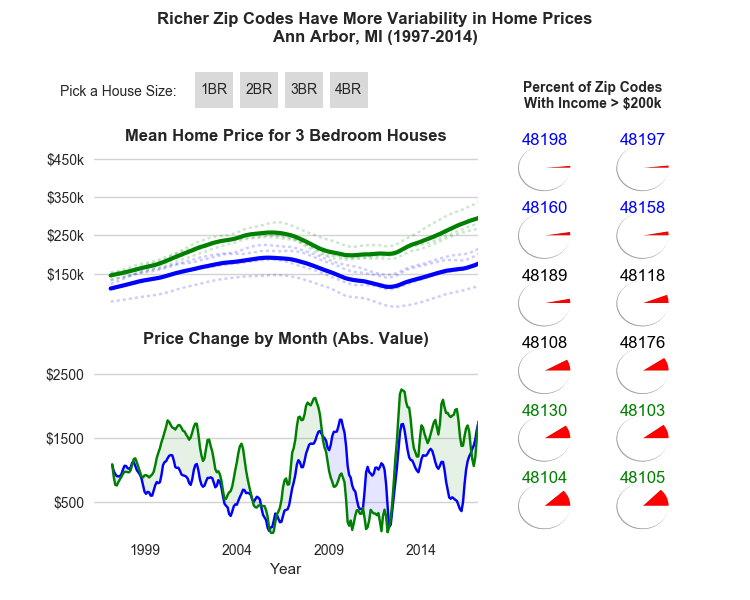

In [9]:
%matplotlib notebook

# Set up the figure within a GridSpec instance
from matplotlib.gridspec import GridSpec
gspec = GridSpec(7,3, width_ratios=(6,1,1))
fig = plt.figure(figsize=(7.5,6), facecolor='white')
fig.suptitle('Richer Zip Codes Have More Variability in Home Prices\nAnn Arbor, MI (1997-2014)', weight='bold')

# Create initial plots (to see source, check out the full notebook)
ax1 = drawTimeseries(3, 12)
ax2 = drawDiffseries(3, 12)
drawZipCodes()
fig.text(.79,0.82, 'Percent of Zip Codes\nWith Income > $200k', ha='center', weight='bold')

# Create Buttons
from matplotlib.widgets import Button

# Create the button shapes
bxstart = 0.26
bystart = 0.82
axb1 = plt.axes([bxstart, bystart, 0.05, 0.06])
bb1 = Button(axb1, '1BR')
axb2 = plt.axes([bxstart+0.06, bystart, 0.05, 0.06])
bb2 = Button(axb2, '2BR')
axb3 = plt.axes([bxstart+0.12, bystart, 0.05, 0.06])
bb3 = Button(axb3, '3BR')
axb4 = plt.axes([bxstart+0.18, bystart, 0.05, 0.06])
bb4 = Button(axb4, '4BR')
fig.text(bxstart-0.1,0.84, 'Pick a House Size: ', ha='center')

# Create a class which redraws the plots based on which button is pressed
class Index(object):
    def drawBR1(self, event):
        ax1 = drawTimeseries(1, 12)
        ax2 = drawDiffseries(1, 12)
        return ax1, ax2

    def drawBR2(self, event):
        ax1 = drawTimeseries(2, 12)
        ax2 = drawDiffseries(2, 12)
        return ax1, ax2

    def drawBR3(self, event):
        ax1 = drawTimeseries(3, 12)
        ax2 = drawDiffseries(3, 12)
        return ax1, ax2

    def drawBR4(self, event):
        ax1 = drawTimeseries(4, 12)
        ax2 = drawDiffseries(4, 12)
        return ax1, ax2   
    
# Instantiate the Index class and connect to button shapes
callback = Index()
bb1.on_clicked(callback.drawBR1)
bb2.on_clicked(callback.drawBR2)
bb3.on_clicked(callback.drawBR3)
bb4.on_clicked(callback.drawBR4)

plt.show()

Voila! Now, we just have to make sure that the figure is drawn in an interactive frame, e.g. by setting the `%matplotlib notebook`  flag in a Jupyter Notebook.